In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from tools.utils.sqlite_utils import create_connection

import pandas as pd
import ast
import re
import pickle
import tiktoken

conn = create_connection('../dataset/CVEfixes_v1.0.8/Data/DB.db')

In [2]:
query = f"""
SELECT
    m.method_change_id,
    m.file_change_id,
    m.name,
    f.programming_language,
    m.start_line,
    m.end_line,
    m.nloc,
    m.before_change,
    cc.cwe_id
FROM method_change AS m
JOIN file_change AS f 
    ON m.file_change_id = f.file_change_id
JOIN commits AS c 
    ON f.hash = c.hash
JOIN fixes AS fx 
    ON c.hash = fx.hash
JOIN cwe_classification AS cc 
    ON fx.cve_id = cc.cve_id
WHERE f.programming_language IN ('PHP', 'JavaScript', 'Java', 'TypeScript', 'Ruby', 'Python')
AND cc.cwe_id IN ('CWE-79', 'CWE-89', 'CWE-434', 'CWE-352')
AND CAST(m.nloc AS INTEGER) < 20  -- Convert TEXT to INT before comparison
"""
method_df = pd.read_sql(query, con=conn)
method_df['nloc'] = pd.to_numeric(method_df['nloc'], errors='coerce')
print(len(method_df))

130831


In [3]:
method_df[method_df['programming_language'] == 'JavaScript'] = method_df[method_df['programming_language'] == 'JavaScript'].groupby('cwe_id', group_keys=False).apply(lambda g: g.sample(frac=1/20, random_state=42))

# First, filter your DataFrame as you originally wanted
filtered_df = method_df[(method_df['programming_language'] == 'PHP') & (method_df['before_change'] == 'False')]

small_size = len(filtered_df) // 10
right_half = filtered_df.iloc[small_size:]
method_df = method_df.drop(right_half.index)

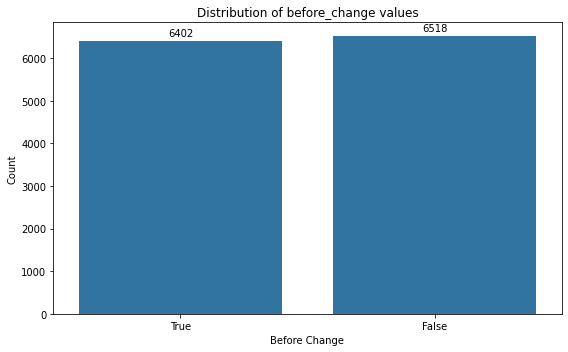

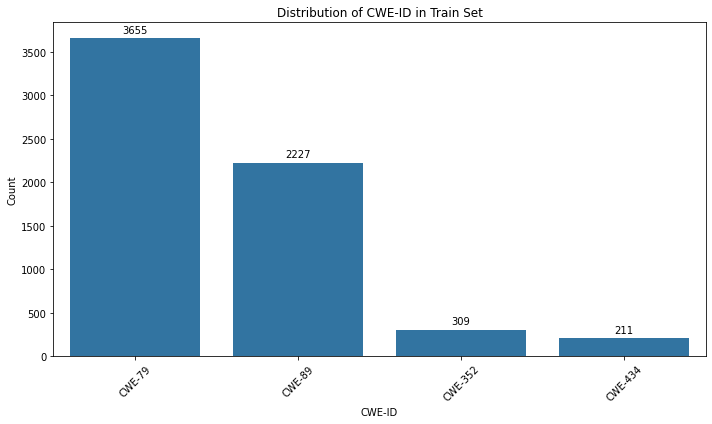

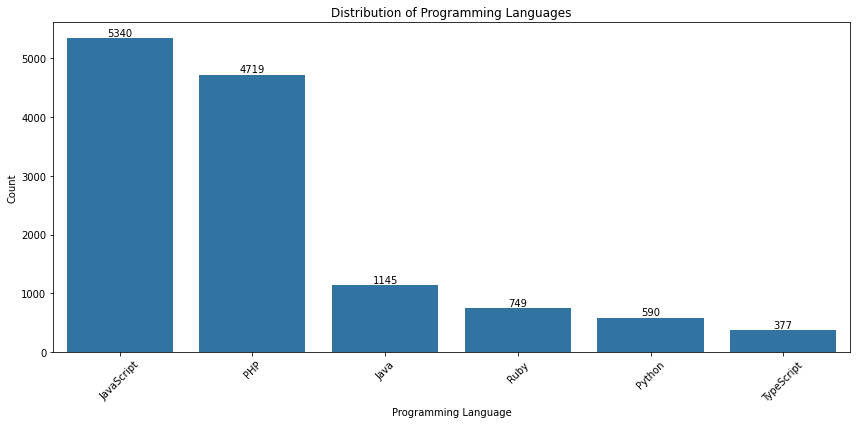

In [26]:
# Show the distiribution of CWE-ID in method_df
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cwe_distribution(df, column_name='cwe_id'):
  plt.figure(figsize=(10, 6))
  ax = sns.countplot(data=df, x=column_name, order=df[column_name].value_counts().index)
  plt.title('Distribution of CWE-ID in Train Set')
  plt.xlabel('CWE-ID')
  plt.ylabel('Count')
  plt.xticks(rotation=45)

  # Add specific numbers on top of each pillar
  for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
          ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
          textcoords='offset points')

  plt.tight_layout()
  plt.show()

def plot_before_change_distribution(df):
  plt.figure(figsize=(8, 5))
  ax = sns.countplot(data=df, x='before_change')
  plt.title('Distribution of before_change values')
  plt.xlabel('Before Change')
  plt.ylabel('Count')

  # Add specific numbers on top of each pillar
  for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
        textcoords='offset points')

  plt.tight_layout()
  plt.show()

def visualize_language_distribution(df):
  plt.figure(figsize=(12, 6))
  lang_counts = df['programming_language'].value_counts()
  ax = sns.barplot(x=lang_counts.index, y=lang_counts.values)  # Set pillar color to red
  plt.title('Distribution of Programming Languages')
  plt.xlabel('Programming Language')
  plt.ylabel('Count')
  plt.xticks(rotation=45)
  
  # Add numbers on top of each bar
  for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
          (p.get_x() + p.get_width() / 2., p.get_height()), 
          ha='center', va='center', 
          xytext=(0, 5), 
          textcoords='offset points')
  
  plt.tight_layout()
  plt.show()

plot_before_change_distribution(method_df)
plot_cwe_distribution(method_df[method_df['before_change']=='True'])
visualize_language_distribution(method_df)


In [5]:
from sklearn.model_selection import train_test_split


def stratified_split(df, test_size=0.2, random_state=42):
    train_dfs = []
    test_dfs = []
    
    # Group by both programming language and CWE
    for (lang, cwe), group_df in df.groupby(['programming_language', 'cwe_id']):
        # Skip groups with 0 samples (unlikely, but safe)
        if len(group_df) == 0:
            continue
        
        # If only 1 sample, add to training to avoid test set contamination
        if len(group_df) == 1:
            train_dfs.append(group_df)
            continue
        
        # Split the group into train and test
        group_train, group_test = train_test_split(
            group_df,
            test_size=test_size,
            random_state=random_state,
            shuffle=True
        )
        train_dfs.append(group_train)
        test_dfs.append(group_test)
    
    # Combine all splits
    train_set = pd.concat(train_dfs, ignore_index=True)
    test_set = pd.concat(test_dfs, ignore_index=True)
    return train_set, test_set

train_vul_df, test_vuln_df = stratified_split(method_df[method_df['before_change'] == 'True'], test_size=0.3, random_state=42)
print('Train Vuln', len(train_vul_df))
print('Test Vuln', len(test_vuln_df))

train_non_vuln_df, test_non_vuln_df = stratified_split(method_df[method_df['before_change'] == 'False'], test_size=0.3, random_state=42)
print('Train Non-Vuln', len(train_non_vuln_df))
print('Test Non-Vuln', len(test_non_vuln_df))

train_vul_df['label'] = train_vul_df['cwe_id']
train_non_vuln_df['label'] = 'non_vuln'
train_df = pd.concat([train_vul_df, train_non_vuln_df], ignore_index=True)
print('Train DF', len(train_df))

test_vuln_df['label'] = test_vuln_df['cwe_id']
test_non_vuln_df['label'] = 'non_vuln'
test_df = pd.concat([test_vuln_df, test_non_vuln_df], ignore_index=True)
print('Test DF', len(test_df))

Train Vuln 4471
Test Vuln 1931
Train Non-Vuln 4552
Test Non-Vuln 1966
Train DF 9023
Test DF 3897


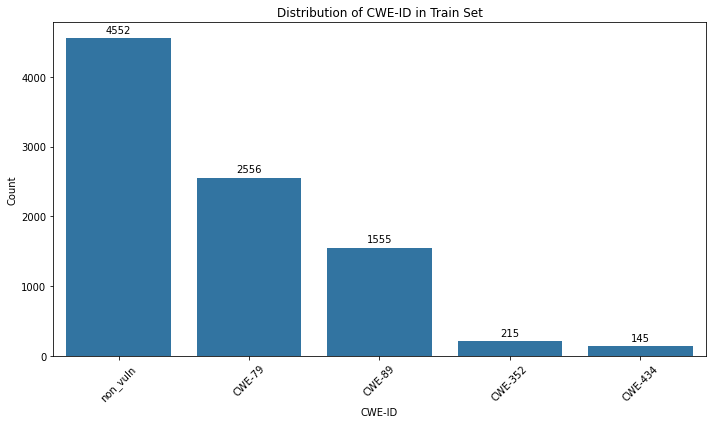

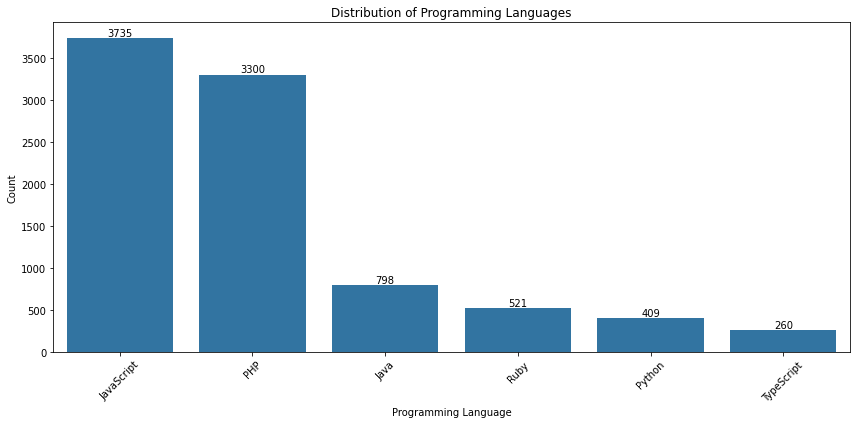

In [27]:
plot_cwe_distribution(train_df, 'label')
visualize_language_distribution(train_df)

In [7]:
query = f"""
SELECT
        f.file_change_id,
        f.code_after AS non_vuln_code,
        f.code_before AS vuln_code,
        f.token_count
FROM file_change f
        INNER JOIN fixes
                ON f.hash = fixes.hash
        INNER JOIN cve
                ON fixes.cve_id = cve.cve_id
        INNER JOIN cwe_classification
                ON cve.cve_id = cwe_classification.cve_id
        INNER JOIN cwe
                ON cwe_classification.cwe_id = cwe.cwe_id
WHERE
        f.programming_language IN ('PHP', 'JavaScript', 'Java', 'TypeScript', 'Ruby', 'Python')
        AND cwe.cwe_id IN ('CWE-79', 'CWE-89', 'CWE-434', 'CWE-352')
        AND f.code_before IS NOT NULL
        AND f.token_count IS NOT NULL;
    """
file_df = pd.read_sql(query, con=conn)
print(len(file_df))

13435


In [8]:
for index, row in train_df.iterrows():
    print(index/len(train_df), end='\r')
    file_id = row['file_change_id']
    label = row['label']
    start_line = row['start_line']
    end_line = row['end_line']
    
    if label == 'non_vuln':
        code_type = 'non_vuln_code'
    else:
        code_type = 'vuln_code'
    
    code = file_df[file_df['file_change_id'] == file_id][code_type].values[0]
    lines = code.splitlines()[int(start_line)-1:int(end_line)]  # Fixed slice notation
    result = "\n".join(lines)
    
    # Using .loc with index is more efficient than searching by file_change_id
    train_df.loc[index, 'code'] = result
  
for index, row in test_df.iterrows():
    print(index/len(test_df), end='\r')
    file_id = row['file_change_id']
    label = row['label']
    start_line = row['start_line']
    end_line = row['end_line']
    
    if label == 'non_vuln':
        code_type = 'non_vuln_code'
    else:
        code_type = 'vuln_code'
    
    code = file_df[file_df['file_change_id'] == file_id][code_type].values[0]
    lines = code.splitlines()[int(start_line)-1:int(end_line)]  # Fixed slice notation
    result = "\n".join(lines)
    
    # Using .loc with index is more efficient than searching by file_change_id
    test_df.loc[index, 'code'] = result

In [31]:
import random

index = random.randint(0, len(test_df))
tmp = train_df[train_df['label'] == 'non_vuln']
print(tmp.iloc[index]['method_change_id'])
print(tmp.iloc[index]['label'])
print(tmp.iloc[index]['code'])

82745440291869
non_vuln
d.removeAttribute("summary")}}]}]},m&&m.createAdvancedTab(a,null,"table")]}}var q=CKEDITOR.tools.cssLength,k=function(a){var e=this.id;a.info||(a.info={});a.info[e]=this.getValue()};CKEDITOR.dialog.add("table",function(a){return n(a,"table")});CKEDITOR.dialog.add("tableProperties",function(a){return n(a,"tableProperties")})})();


In [32]:
train_df.to_pickle("../dataset/train_df_func.pkl")
test_df.to_pickle("../dataset/test_df_func.pkl")

In [34]:
train_df[train_df['programming_language'] == 'PHP'].to_pickle("../dataset/train_df_func_PHP.pkl")
train_df[train_df['programming_language'] == 'JavaScript'].to_pickle("../dataset/train_df_func_JS.pkl")

In [35]:
train_df

,method_change_id,file_change_id,name,programming_language,start_line,end_line,nloc,before_change,cwe_id,label,code
0,104685527378434,199037997425301,HttpRequestHandler::checkClientIPAccess,Java,281,285,5.0,True,CWE-352,CWE-352,public void checkClientIPAccess(String pHo...
1,132096067065412,193374663827426,CreateActionTest::newDocumentWebHomeButTermina...,Java,265,292,17.0,True,CWE-352,CWE-352,void newDocumentWebHomeButTerminalFromURL(...
2,183906153218874,193374663827426,CreateActionTest::newDocumentWebHomeFromURL,Java,237,262,16.0,True,CWE-352,CWE-352,void newDocumentWebHomeFromURL() throws Ex...
3,55266896876267,193374663827426,CreateActionTest::newDocumentWebHomeTopLevelFr...,Java,210,234,16.0,True,CWE-352,CWE-352,void newDocumentWebHomeTopLevelFromURL() t...
4,176332274748794,279484349798014,HttpRequestHandlerTest::accessDenied,Java,72,77,5.0,True,CWE-352,CWE-352,public void accessDenied() {\n expe...
...,...,...,...,...,...,...,...,...,...,...,...
9018,108591795278411,80362477205770,c.amount,TypeScript,106,114,9.0,False,CWE-79,non_vuln,"? `${c.amount(a.value, a.curre..."
9019,176058316263243,42955047710529,validateUrl,TypeScript,12,29,15.0,False,CWE-79,non_vuln,"): boolean => {\n const { allowedSchemes, isU..."
9020,147388470633125,210385506318845,update,TypeScript,44,44,1.0,False,CWE-79,non_vuln,): { destroy: () => void; update: (t: () => To...
9021,239788865929483,255575629232229,metaConfigExtended,TypeScript,182,188,7.0,False,CWE-89,non_vuln,async metaConfigExtended(options) {\n con...
